In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
import torch.utils.data as udata
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Generation of 1D piecewise constant signals
class PieceWiseConstantDataset(udata.Dataset):

    def __init__(self, n_data = 1000, n_signal = 40, prob=0.3, fix_datapoints = True,
                  min_val = 0, max_val = 1, min_sep = 20, min_diff=0.4, use_circular_shift=True, circular_shift_get_item= False, seed=0, shift_item = False):
        super(PieceWiseConstantDataset, self).__init__()

        assert(min_sep > 0)
        self.n_data = n_data;
        self.n_signal = n_signal;
        self.prob = prob
        self.fix_datapoints = fix_datapoints;
        self.min_val = min_val;
        self.max_val = max_val;
        self.min_sep = min_sep;
        self.min_diff = min_diff
        assert min_diff < (max_val-min_val)/2

        self.use_circular_shift = use_circular_shift
        self.circular_shift_get_item = circular_shift_get_item
        self.shift_item =shift_item

        np.random.seed(seed)

        if self.fix_datapoints:
            self.data_list = [None] * self.n_data;
            for i in range(self.n_data):
                # self.data_list[i] = self.gen_piecewise_constant(self.n_signal, self.prob, min_val=self.min_val, max_val=self.max_val);
                self.data_list[i] = self.gen_piecewise_constant_minsep(self.n_signal, self.prob, self.min_sep,
                                                    min_val=self.min_val, max_val=self.max_val);

    def __len__(self):
        return self.n_data

    def circular_shift_shift(self, signal, shift):
        return np.roll(signal, shift)

    def circular_shift(self, signal, shift):
        if shift > int(self.n_signal/2):
          return np.flip(signal).copy()
        else:
          return signal


    def gen_piecewise_constant(self, n, prob, min_val, max_val):
        # np.random.seed(seed)  # Set the seed for reproducibility
        min_diff = self.min_diff
        signal = np.zeros(n)
        val = np.random.uniform(min_val, max_val);
        ind = np.random.randint(n)
        for i in range(n):
            signal[ind] = val
            if np.random.rand() < prob:

                new_val = np.random.uniform(min_val, max_val)
                # Ensure the new value differs from the old value by at least min_diff
                while abs(new_val - val) < min_diff:
                    new_val = np.random.uniform(min_val, max_val)
                val = new_val
                # val = np.random.uniform(min_val, max_val);
            ind = np.mod(ind + 1,n)
        return signal

    def gen_piecewise_constant_minsep(self, n, prob, minsep, min_val, max_val):
        # np.random.seed(seed)  # Set the seed for reproducibility
        signal = np.zeros(n)
        ind = 0
        val = np.random.uniform(min_val, max_val);
        while ind < n:
            if ind + minsep > n:
                signal[ind:] = val
                break
            if ind == 0 or np.random.rand() < prob:
                val = np.random.uniform(min_val, max_val);
                sep = np.random.randint(1, minsep+1) if ind == 0 else minsep;
                if ind + sep > n:
                    signal[ind:] = val
                    break
                else:
                    signal[ind:(ind+sep)] = val
                    ind += sep
            else:
                signal[ind] = val
                ind += 1
        if self.use_circular_shift:
          shift = np.random.randint(n)
          # print(signal)
          signal = self.circular_shift(signal, shift)
        return signal

    def __getitem__(self, index):

        if self.fix_datapoints:
            signal = self.data_list[index];
        else:
            # signal = self.gen_piecewise_constant(self.n_signal, self.prob, min_val=self.min_val, max_val=self.max_val);
            signal = self.gen_piecewise_constant_minsep(self.n_signal, self.prob, self.min_sep,
                                                    min_val=self.min_val, max_val=self.max_val);

        if self.circular_shift_get_item:
          shift = np.random.randint(self.n_signal)
          if not self.shift_item:
            signal = self.circular_shift(signal, shift)
          else:
            signal = self.circular_shift_shift(signal, shift)



        return torch.from_numpy(signal).unsqueeze(0).type(torch.FloatTensor)

In [3]:
# Generation of noise
def get_noise(signal, noise_std=0.1, noise_scale=1, max_noise=1,  mode='G'):
    if mode == 'poisson':
        scaled_signal = signal * noise_scale
        noise_sample = torch.tensor(np.random.poisson(scaled_signal.numpy()))
        noise = (noise_sample - scaled_signal) / noise_scale
    else:
        noise = torch.normal(0, noise_std, size=signal.shape)

    noise = torch.clamp(noise, -max_noise, max_noise)
    return noise


In [4]:
# Evaluation of denoising error
def evaluate_error(model, dataset_val, noise_std):
    model.eval()
    error_val = 0;
    total_length = 0;

    criterion = nn.MSELoss(reduction='mean');

    for data in dataset_val:
        out_val = model(data + get_noise(data, noise_std) );
        error_val += criterion(out_val, data).item()
        total_length += 1;

    return error_val/total_length

In [5]:
# Train network in a supervised fashion with continuous noise sampling
def train_network(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + get_noise(data, noise_std) );

            loss = criterion(out_train, data);
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = evaluate_error(model, train_loader, noise_std)
        val_loss[epoch] =  evaluate_error(model, val_loader, noise_std)

        if epoch % 10 == 0:
            print(epoch, 'train error: ', train_loss[epoch],'validation error: ',val_loss[epoch])

    return train_loss, val_loss

In [6]:
# Train network in an unsupervised fashion with continuous noise sampling following the Noise2Noise framework
def train_network_noise2noise(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + get_noise(data, noise_std) );
            target = data + get_noise(data, noise_std)

            loss = criterion(out_train, target)
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = evaluate_error(model, train_loader, noise_std)
        val_loss[epoch] =  evaluate_error(model, val_loader, noise_std)

        if epoch % 10 == 0:
            print(epoch, 'train error: ', train_loss[epoch],'validation error: ',val_loss[epoch])

    return train_loss, val_loss

In [7]:
# 1D convolutional neural network with skip connection
class CNN(nn.Module):
	def __init__(self, depth=20, n_channels=16, image_channels=1, use_bnorm=True, kernel_size=3, use_bias=True, non_linear=True):
		super(CNN, self).__init__()
		kernel_size = 3
		padding = 1

		self.use_bnorm = use_bnorm;
		self.depth = depth;
		self.use_bias= use_bias
		self.non_linear = non_linear


		self.first_layer = nn.Conv1d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self.hidden_layer_list = [None] * (self.depth - 2);
		if self.use_bnorm:
			self.bn_layer_list = [None] * (self.depth -2 );

		for i in range(self.depth-2):
			self.hidden_layer_list[i] = nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias);
			if self.use_bnorm:
				self.bn_layer_list[i] = nn.BatchNorm1d(n_channels, eps=0.0001, momentum = 0.95)

		self.hidden_layer_list = nn.ModuleList(self.hidden_layer_list);
		if self.use_bnorm:
			self.bn_layer_list = nn.ModuleList(self.bn_layer_list);
		self.last_layer = nn.Conv1d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self._initialize_weights()

	def forward(self, x):

		out = self.first_layer(x);
		if self.non_linear:
			out = F.relu(out);

		for i in range(self.depth-2):
			out = self.hidden_layer_list[i](out);
			if self.use_bnorm:
				out = self.bn_layer_list[i](out);
			if self.non_linear:
				out = F.relu(out)

		out = self.last_layer(out) + x;

		return out

	def _initialize_weights(self):
		for m in self.modules():
			if isinstance(m, nn.Conv1d):
				init.orthogonal_(m.weight)
				# print('init weight')
				if m.bias is not None:
					init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm1d):
				init.constant_(m.weight, 1)
				init.constant_(m.bias, 0)

In [8]:
# Generate training and validation datasets
prob_val = 0.3
min_sep = 5
signal_length = 100
n_small = 10
n_large = 500
train_dataset_small = PieceWiseConstantDataset(n_data = n_small, prob = prob_val, n_signal = signal_length, fix_datapoints = True, min_sep = min_sep, use_circular_shift=False, circular_shift_get_item=False)
train_dataset_large = PieceWiseConstantDataset(n_data = n_large, prob = prob_val, n_signal = signal_length, fix_datapoints = True, min_sep = min_sep, use_circular_shift=False, circular_shift_get_item=False)
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = prob_val, min_sep =min_sep, use_circular_shift=False,circular_shift_get_item=False);
train_loader_small = DataLoader(dataset=train_dataset_small,
                          num_workers=0,
                          batch_size=32, shuffle=True);
train_loader_large = DataLoader(dataset=train_dataset_large,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [9]:
noise_std = 0.1

In [10]:
# Train network in a supervised manner on small dataset
nn_supervised_small = CNN(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_supervised_small, val_loss_supervised_small = train_network(nn_supervised_small, train_loader_small, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.009990079328417778 validation error:  0.009980087396688759
10 train error:  0.006524849683046341 validation error:  0.006688739266246557
20 train error:  0.004532329272478819 validation error:  0.004461064494680613
30 train error:  0.0035822007339447737 validation error:  0.0038205621344968676
40 train error:  0.0034693721681833267 validation error:  0.0036967926379293204
50 train error:  0.003374195657670498 validation error:  0.003289357747416943
60 train error:  0.003204719629138708 validation error:  0.003281910545192659
70 train error:  0.00305259064771235 validation error:  0.0031451208784710615
80 train error:  0.00294193415902555 validation error:  0.0035750961257144808
90 train error:  0.003124637994915247 validation error:  0.0031402640417218207


In [11]:
# Train network in a supervised manner on large dataset
nn_supervised_large = CNN(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_supervised_large, val_loss_supervised_large = train_network(nn_supervised_large, train_loader_large, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.004749173443997279 validation error:  0.004832627137657255
10 train error:  0.00259467851719819 validation error:  0.0024833805835805835
20 train error:  0.0024234940065070987 validation error:  0.002490740866633132
30 train error:  0.0023759535688441247 validation error:  0.0024042085913242774
40 train error:  0.002345780929317698 validation error:  0.002246774919331074
50 train error:  0.002450197673169896 validation error:  0.00255366045050323
60 train error:  0.0022096599204814993 validation error:  0.0022488649154547603
70 train error:  0.002318942337296903 validation error:  0.0023126058909110725
80 train error:  0.002297893508512061 validation error:  0.0021278215479105713
90 train error:  0.0022350284998537973 validation error:  0.002239890446071513


In [12]:
# Train network in an unsupervised manner on small dataset
nn_unsupervised_small = CNN(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_unsupervised_small, val_loss_unsupervised_small = train_network_noise2noise(nn_unsupervised_small, train_loader_small, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.010395475663244724 validation error:  0.010020100260153413
10 train error:  0.005928934086114168 validation error:  0.006203525373712182
20 train error:  0.004600818734616041 validation error:  0.00485800406197086
30 train error:  0.004285705275833607 validation error:  0.004424432038795203
40 train error:  0.003614787245169282 validation error:  0.003842680836096406
50 train error:  0.004030360374599695 validation error:  0.0038413505256175997
60 train error:  0.003951383288949728 validation error:  0.004099883695598692
70 train error:  0.0033025743905454874 validation error:  0.003729196658823639
80 train error:  0.0035836014430969954 validation error:  0.0036283197766169904
90 train error:  0.003626341000199318 validation error:  0.003748927318956703


In [13]:
# Train network in an unsupervised manner on large dataset
nn_unsupervised_large = CNN(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_unsupervised_large, val_loss_unsupervised_large = train_network_noise2noise(nn_unsupervised_large, train_loader_large, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)

0 train error:  0.010142931598238647 validation error:  0.010251413537189365
10 train error:  0.009968498779926449 validation error:  0.009941179906018078
20 train error:  0.0035673895326908678 validation error:  0.003568334127776325
30 train error:  0.0031642678222851828 validation error:  0.0030115414841566236
40 train error:  0.0028151976293884218 validation error:  0.0029031030694022775
50 train error:  0.002810122590744868 validation error:  0.002729837285587564
60 train error:  0.002650669703143649 validation error:  0.0026009252842050046
70 train error:  0.002568004696513526 validation error:  0.002591492262436077
80 train error:  0.002549337688833475 validation error:  0.002549025623011403
90 train error:  0.00257234979653731 validation error:  0.002547170964535326


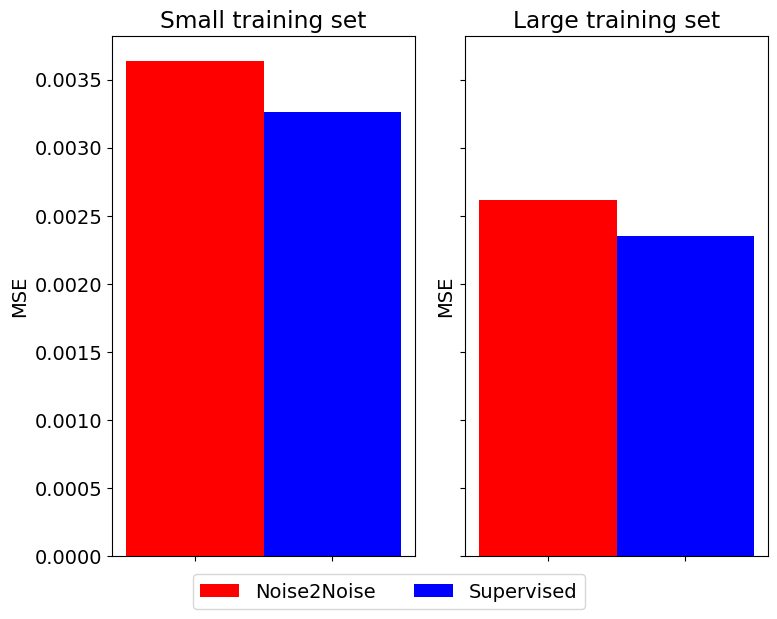

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Colors and fine-tuning sets as specified
category_colors = {
    'Noise2Noise': 'red',
    'Supervised': 'blue'
}

ft_sets = {
    'Small training set': [('Noise2Noise', val_loss_unsupervised_small[-1]), ('Supervised', val_loss_supervised_small[-1])],
    'Large training set': [('Noise2Noise', val_loss_unsupervised_large[-1]), ('Supervised', val_loss_supervised_large[-1])],
}

fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True)  # Width remains decreased

bar_width = 0.1
plt.rcParams.update({'font.size': 14})

legend_labels = {}

for ax, (ft_set, data_tuples) in zip(axs, ft_sets.items()):
    for j, (data_type, size) in enumerate(data_tuples):
        position = j * bar_width
        ax.bar(position, size, width=bar_width, color=category_colors[data_type], label=data_type if data_type not in legend_labels else "")
        legend_labels[data_type] = category_colors[data_type]

    # Adjust the axes and labels
    ax.set_xticks(np.arange(len(data_tuples)) * bar_width)
    ax.set_xticklabels([])
    ax.set_ylabel('MSE')
    ax.set_title(f'{ft_set}')

# Adjust subplot layout}
plt.tight_layout()

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, -0.05))
plt.show()